# Resampling Echelle Spectrum for the Pandeia ETC

## Introduction
In May 2023, the Pandeia Exposure Time Calculator (ETC) system is released and replaces the old ETC system for the Hubble Space Telescope (HST). Pandeia is a pixel-based exposure time calculator paired with a modern graphical user interface. It's based on a Python engine that calculates three-dimensional data cubes from user-specified spatial and spectral properties of one or more sources.

Pandeia has the functionality to conduct the ETC calculation based on user-supplied STIS spectra. While STIS CCD and FUV-MAMA spectra can be directly uploaded, the resolution of the NUV-MAMA echelle spectroscopy is too high for the ETC to parse the spectra.

In this notebook, we demonstrate the steps to downsample NUV-MAMA echelle spectra to reduce resolution, and to reformat the spectra fits file for the ETC. (The file reformatting is applicable to CCD and FUV-MAMA as well).

### Import Necessary Packages
- `astropy.io.fits` and `astropy.table.Table` for accessing FITS files
- `astroquery.mast.Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `astropy.units` for specifying astronomical units
- `numpy` to handle array functions
- `stistools.splice` for manipulating echelle spectra
- `specutils.Spectrum1D` and `specutils.manipulation.FluxConservingResampler` for resampling spectra
- `matplotlib` for plotting data

In [24]:
# Import for: Reading in fits file
from astropy.io import fits
from astropy.table import Table

# Import for: Downloading necessary files.
# (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Specifying astronomical units
import astropy.units as u

# Import for: Quick Calculation and Data Analysis
import numpy as np

# Import for: Manipulating STIS Spectra
from stistools.splice import splice

# Import for: Resampling Spectra
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler 

# Import for: Plotting and specifying plotting parameters
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]

import pysynphot

### Collect Data Set From the MAST Archive Using Astroquery
There are other ways to download data from MAST such as using CyberDuck. The steps of collecting data is beyond the scope of this notebook, and we are only showing how to use astroquery.

The dataset OCTX01030 is observed in NUV-MAMA echelle mode with the E230M grating and $0.2 \times 0.2$ aperture. The exposure time is 1872 seconds

In [2]:
# Search target object by obs_id
obs = Observations.query_criteria(obs_id=['OCTX01030'])
pl = Observations.get_product_list(obs)
# Download the _x1d spectrum
pl = pl[pl['productSubGroupDescription'].filled() == 'X1D']
dl = Observations.download_products(pl)
filename = dl['Local Path'][0]
filename

INFO: Found cached file ./mastDownload/HST/octx01030/octx01030_x1d.fits with expected size 7629120. [astroquery.query]


'./mastDownload/HST/octx01030/octx01030_x1d.fits'

## Introduction to STIS Echelle Spectroscopy
In echelle spectroscopy, the spectra is dispersed into different spectral orders to have higher spectral resolution. STIS has four echelle grating modes which provide spectroscopic coverage from ~1145 Å to 3100 Å at resolving powers from R ~30,000 to R ~114,000.

In STIS fits files, the echelle data is organized in a table format such that each spectral order (SPORDER) is stored in a single row of the table. The complete spectra can be accessed by iterating over the rows in the first extension.

For more information, see [Echelle Spectroscopy in the Ultraviolet](https://hst-docs.stsci.edu/stisihb/chapter-4-spectroscopy/4-3-echelle-spectroscopy-in-the-ultraviolet) and [view_data](https://htmlpreview.github.io/?https://github.com/spacetelescope/STIS-Notebooks/blob/main/view_data/view_data.html).

### Plotting Echelle Spectra
We first read in the echelle spectra from the fits file first extension, and plot the spectra of different SPORDER in alternative colors. As shown in the plot, adjacent spectral orders have wavelength overlaps.

(-2e-13, 3e-12)

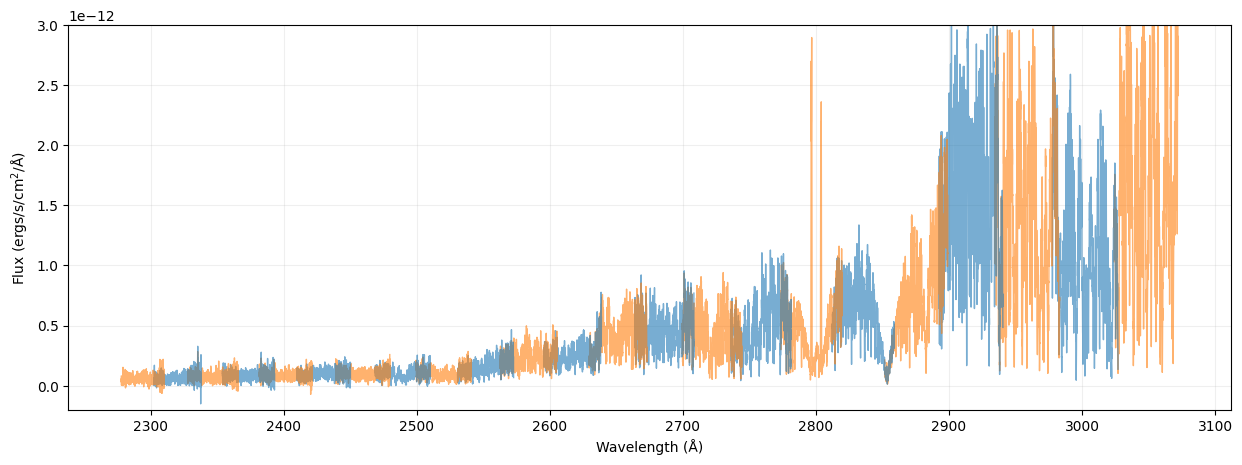

In [3]:
# Read in data from the first extension
d = fits.getdata(filename, ext=1)

# Iterate through the spectral orders and plot the spectrum in alternative colors
for order in d:
    g = (order['DQ'] & fits.getval(filename, ext=1, keyword='SDQFLAGS')) == 0
    plt.plot(order['WAVELENGTH'][g], order['FLUX'][g], alpha=0.6, linewidth=1, color=f"C{order['SPORDER'] % 2}")

plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (ergs/s/cm$^{2}$/Å)')
plt.grid(True, alpha=0.2)
plt.ylim(-2e-13, 3e-12)

### Splicing Echelle Spectra
TODO: add some explanation on splice

(-2e-13, 3e-12)

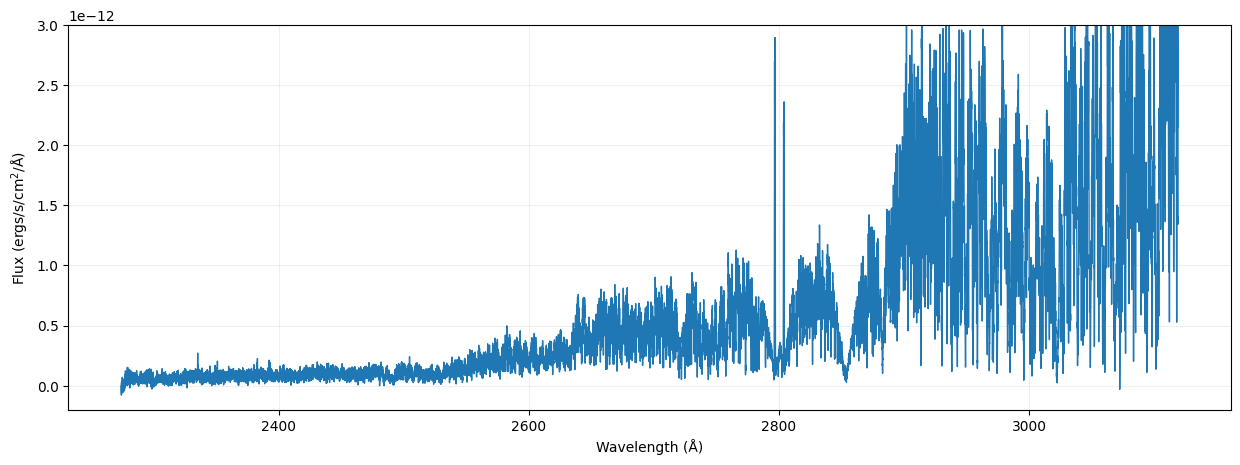

In [4]:
spliced = splice(filename)
plt.plot(spliced['WAVELENGTH'], spliced['FLUX'], linewidth=1)

plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (ergs/s/cm$^{2}$/Å)')
plt.grid(True, alpha=0.2)
plt.ylim(-2e-13, 3e-12)

In [5]:
spliced

WAVELENGTH,FLUX,ERROR,DQ
float64,float64,float64,int64
2274.303666679877,-1.849007702319199e-15,4.733922220160965e-17,2628
2274.341169378231,-7.661628493096928e-14,6.486138382336452e-16,2628
2274.3786718871556,-7.851790777887308e-14,3.647482774257922e-14,2628
2274.416174206652,-1.4809891662093295e-14,1.4965484838240332e-14,2628
2274.453676336723,1.167646013921662e-14,2.9525867699126823e-14,2628
2274.4911782773725,3.008735906359812e-14,4.1828787476902093e-14,576
...,...,...,...
3118.662327739209,3.4798355603299358e-12,3.031892770698208e-13,2048
3118.712358478336,3.080259354873438e-12,2.894739569575533e-13,2048


In [6]:
t = Table(data={'WAVELENGTH': spliced['WAVELENGTH'], 'FLUX': spliced['FLUX'],},
          units={'WAVELENGTH': u.Angstrom, 'FLUX': u.erg * u.s**-1 * u.cm**-2 * u.Angstrom**-1})

t.write('echelle_nuv_full_spec.fits', overwrite=True)

In [7]:
fluxcon = FluxConservingResampler()
lamb = spliced['WAVELENGTH']
flux = spliced['FLUX']

# Zero out Lyman-𝜶 air glow line:
flux[(lamb >= (1215.67 - 5)) & (lamb < 1215.67 + 5)] = 0.

# Apply units:
lamb *= u.AA
flux *= u.Unit('erg cm-2 s-1 AA-1')

input_spec = Spectrum1D(spectral_axis=lamb, flux=flux)

new_disp_grid = np.arange(spliced['WAVELENGTH'][0], spliced['WAVELENGTH'][-1], 0.2) * u.AA
print (f"Sampling:  {len(lamb)} --> {len(new_disp_grid)}  ({len(new_disp_grid) / len(lamb) * 100:.1f}%)")
new_spec_fluxcon = fluxcon(input_spec, new_disp_grid)

Sampling:  19355 --> 4224  (21.8%)


/Users/kding/miniconda3/envs/stistools_leo/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(2232.070724620221, 3161.1954499326525)

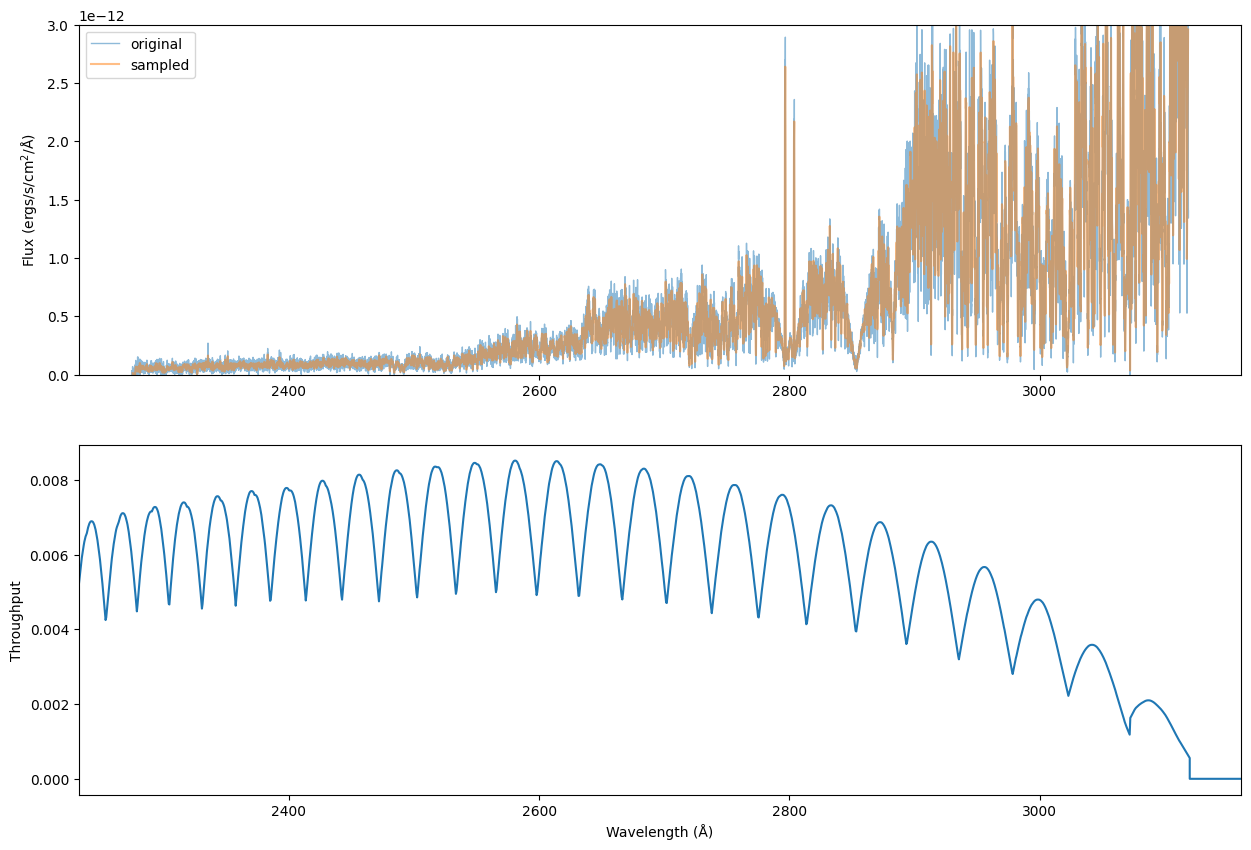

In [23]:
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(15, 5*len(axes))

mask = (new_spec_fluxcon.flux > 0) 
axes[0].plot(spliced['WAVELENGTH'], spliced['FLUX'], linewidth=1, label='original', alpha=0.5)
axes[0].plot(new_spec_fluxcon.wavelength[mask], new_spec_fluxcon.flux[mask], label='sampled', alpha=0.5)
axes[0].set_ylim(0,0.3e-11)
axes[0].legend(loc='best')
axes[0].set_ylabel('Flux (ergs/s/cm$^{2}$/Å)')

bp = pysynphot.ObsBandpass('stis,E230M')
axes[1].plot(bp.wave, bp.throughput)
axes[1].set_xlabel('Wavelength (Å)')
axes[1].set_ylabel('Throughput')
axes[1].set_xlim(*axes[0].get_xlim())

In [25]:
def rle(inarray):
    """Run Length Encoding
    Partial credit to R rle function. 
    Multi datatype arrays catered for including non-Numpy

    From https://stackoverflow.com/a/32681075

    RETURNS
    -------
    tuple (runlengths, startpositions, values)
    """
    ia = np.asarray(inarray)                # force numpy
    n = len(ia)
    if n == 0: 
        return (None, None, None)
    else:
        y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions

        return z, p, ia[i]

In [40]:
wave = spliced['WAVELENGTH']
flux = spliced['FLUX']
runlengths, startpositions, values = rle(spliced['FLUX'])
smooth_indices = (runlengths >= 10) & (values > 0)
smooth_start = startpositions[smooth_indices]
smooth_stop  = startpositions[smooth_indices] + runlengths[smooth_indices]  # exclusive index on right

In [43]:
smooth_start

array([], dtype=int64)

(1100.0, 1500.0)

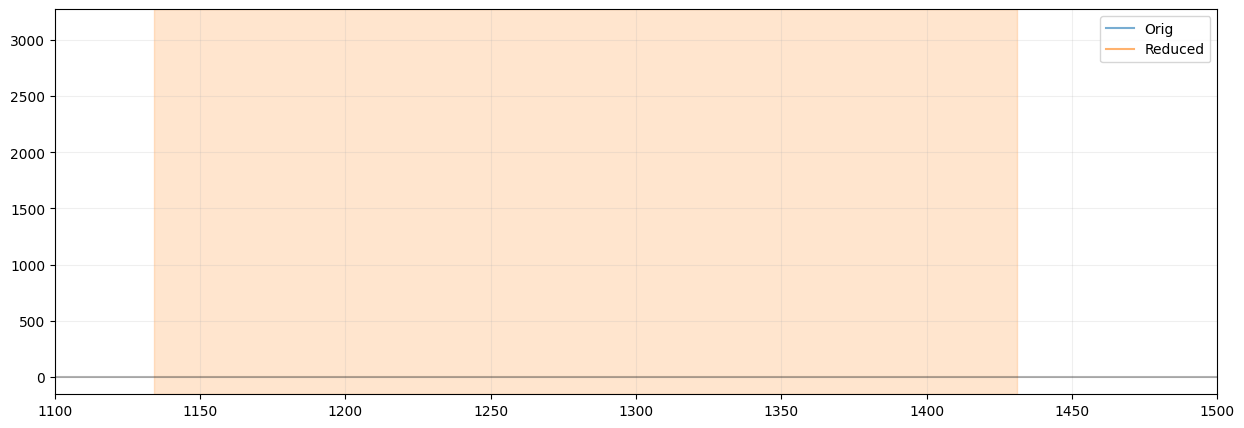

In [42]:
wave_spliced = []
flux_spliced = []
i = 0
for start, stop, steps in zip(smooth_start, smooth_stop, runlengths[smooth_indices]):
    if i != 0:
        # Prior segment of line:
        wave_spliced += list(wave[i:start])
        flux_spliced += list(flux[i:start])

    # Segment of continuum:
    w = np.linspace(wave[start], wave[stop], num=steps//30, endpoint=False)
    f = spl(w)
    wave_spliced += list(w)
    flux_spliced += list(f)

    i = stop

wave_spliced += list(wave[i:])
flux_spliced += list(wave[i:])

wave_spliced = np.array(wave_spliced)
flux_spliced = np.array(flux_spliced)

plt.plot(wave, flux, alpha=0.6, label='Orig')
plt.axhline(1e-14, alpha=0.3, color='k')
plt.plot(wave_spliced, flux_spliced, alpha=0.6, label='Reduced')
plt.legend(loc='best')

plt.grid(True, alpha=0.2)
plt.axvspan(1134, 1431, color='C1', alpha=0.2)
plt.xlim(1100, 1500)


In [ ]:
t = Table(data={'WAVELENGTH': new_spec_fluxcon.wavelength[mask], 'FLUX': new_spec_fluxcon.flux[mask],},
          units={'WAVELENGTH': u.Angstrom, 'FLUX': u.erg * u.s**-1 * u.cm**-2 * u.Angstrom**-1})

In [ ]:
t.write('echelle_nuv_sampled_spec.fits', overwrite=True)

In [ ]:
np.mean(spliced['WAVELENGTH'][1:-1]-spliced['WAVELENGTH'][0:-2])

In [ ]:
min(spliced['WAVELENGTH'])

In [18]:
fits.getheader(filename)

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS file may contain extensions               
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2022-12-19' / date this file was written (yyyy-mm-dd)                
NEXTEND =                    8 / Number of extensions                           
FILENAME= 'octx01030_x1d.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             